https://mcatalano26.github.io/Data-Science-Final-Project/

https://github.com/mcatalano26/Data-Science-Final-Project

The first link is a link to the github.io site. The second link is to the github page where you can easily find all of our data.

# Final Tutorial: The Happiness Project

## Intro
This project is a collaboration between Matt Catalano and Eli Mendels for our Data Science class with Nick Mattei. We will be examining what metrics correspond to national happiness and then trying to predict which counties in the US will be the happiest.

## Housekeeping Stuff

The first few lines of code will install all of the libraries that we will use throughout this project.

In [1]:
pip install geopandas

     |████████████████████████████████| 921kB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 1.5MB 9.6MB/s eta 0:00:01
     |████████████████████████████████| 11.8MB 3.3MB/s eta 0:00:01
     |████████████████████████████████| 10.1MB 4.4MB/s eta 0:00:01    |██████████████                  | 4.4MB 4.4MB/s eta 0:00:02
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install PyShp

     |████████████████████████████████| 225kB 2.1MB/s eta 0:00:01
  Created wheel for PyShp: filename=pyshp-2.1.0-cp37-none-any.whl size=32607 sha256=35cb04745a3d2579c86e094f9daad3f9c301e234634eda10df1af513218b889a
  Stored in directory: /home/jovyan/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built PyShp
Note: you may need to restart the kernel to use updated packages.


In [4]:
#Importing all the necesary libraries. 
import sqlite3
import pandas as pd

import geopandas as geo
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import re
import seaborn as sns
import sklearn
from sklearn import linear_model
import random
import shapefile

#The below is for formatting and taken from past labs written by Nick Mattei
#This lets us show plots inline and also save PDF plots if we want them
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.style.use('fivethirtyeight')

# These two things are for Pandas, it widens the notebook and lets us display data easily.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Show all the rows of a dataframe
pd.options.display.max_rows = 10000
pd.options.display.width = 1000

## Examining the Country Data
In looking at the country data, the first step is to read it into a dataframe. Once the data has been read, we will clean it to prepare it for analysis and add any other data that we deem important.

### Reading in the Data

#### World Factbook Data

Most of our country data will come from the CIA world factbook. We got the data in csv format from https://github.com/thewiremonkey/factbook.csv. 
The data is formatted in a collection of spreadsheets each of which contains three columns: a rank, the name, and the value. Each spreadsheet contains one measurement, for example population, so they must be iterated over and then each spreadsheet must be joined on name to the cumulative table.

Information about the dataset is found in the categories csv which gives a code and names the measurement for each spreadsheet. This is what will be iterated over to generate the factbook dataframe.

In [5]:
#Reading in a summary of the csv files
categories_df = pd.read_csv('categories.csv')
categories_df.head()

Num            Category                    Name
0  2147           Geography                    Area
1  2119  People and Society              Population
2  2002  People and Society  Population growth rate
3  2054  People and Society              Birth rate
4  2066  People and Society              Death rate

In [6]:
#A string to store part of the file names
csv_string = 'WorldFactBookData/c'
#Temporary dataframe to store csvs that need to be added to the dataframe. 
#It's used here to ge the names of each country
df_to_add = pd.read_csv('WorldFactBookData/c2147.csv')
#Creating the dataframe with just the names
factbook_df = pd.DataFrame({'Name' : df_to_add['Name']})


In [7]:
#Iterating through each file code in the categories list and adding the csv to the dataframe
for index, row in categories_df.iterrows():
    file_name = csv_string  + str(row['Num']) + '.csv'
    df_to_add = pd.read_csv(file_name)
    df_to_add = df_to_add.drop(columns=['Pos'])
    column_name = row['Name']
    df_to_add = df_to_add.rename(columns={"Value": column_name})
    factbook_df = factbook_df.merge(df_to_add, how = 'left')

In [8]:
factbook_df.head()

Name      Area    Population  Population growth rate  Birth rate  Death rate  Net migration rate  Maternal mortality rate  Infant mortality rate  Life expectancy at birth  ...  Natural gas - imports  Natural gas - proved reserves  Telephones - fixed lines  Telephones - mobile cellular  Internet users  Airports  Railways   Roadways  Waterways Military expenditures
0         Russia  17098242  1.424238e+08                   -0.04       11.60       13.69                1.69                     34.0                   6.97                     70.47  ...           8.200000e+09                   4.780000e+13                39430000.0                  2.210000e+08      84400000.0    1218.0   87157.0  1283387.0   102000.0                  3.49
1         Canada   9984670  3.509984e+07                    0.75       10.28        8.42                5.66                     12.0                   4.65                     81.76  ...           2.670000e+10                   1.889000e+12                16600000.0                  2.950000e+07      32400000.0    1467.0   46552.0  1042300.0      636.0                  1.24
2  United States   9826675  3.213689e+08                    0.78       12.49        8.15                3.86                     21.0                   5.87                     79.68  ...           8.163000e+10                   8.734000e+12               129400000.0                  3.174000e+08     276600000.0   13513.0  224792.0  6586610.0    41009.0                  4.35
3          China   9596960  1.367485e+09                    0.45       12.49        7.53               -0.44                     37.0                  12.44                     75.41  ...           5.190000e+10                   3.300000e+12               249400000.0                  1.300000e+09     626600000.0     507.0   86000.0  4106387.0   110000.0                  1.99
4         Brazil   8514877  2.042598e+08                    0.77       14.46        6.58               -0.14                     56.0                  18.60                     73.53  ...           1.385000e+10                   3.887000e+11                44100000.0                  2.807000e+08     108200000.0    4093.0   28538.0  1580964.0    50000.0                  1.47

[5 rows x 74 columns]

### Happiness Data

Now that we have a dataframe that stores our data about each country, it's time to look at the results of the happiness survey for each country. This process is fairly easy because it is already in one csv file ready to go.

In [9]:
happiness_df = pd.read_csv('2015.csv')

In [10]:
happiness_df.head()

Country          Region  Happiness Rank  Happiness Score  Standard Error  Economy (GDP per Capita)   Family  Health (Life Expectancy)  Freedom  Trust (Government Corruption)  Generosity  Dystopia Residual
0  Switzerland  Western Europe               1            7.587         0.03411                   1.39651  1.34951                   0.94143  0.66557                        0.41978     0.29678            2.51738
1      Iceland  Western Europe               2            7.561         0.04884                   1.30232  1.40223                   0.94784  0.62877                        0.14145     0.43630            2.70201
2      Denmark  Western Europe               3            7.527         0.03328                   1.32548  1.36058                   0.87464  0.64938                        0.48357     0.34139            2.49204
3       Norway  Western Europe               4            7.522         0.03880                   1.45900  1.33095                   0.88521  0.66973                        0.36503     0.34699            2.46531
4       Canada   North America               5            7.427         0.03553                   1.32629  1.32261                   0.90563  0.63297                        0.32957     0.45811            2.45176

## Combining the Country Data

The next step is to combine the two data sets with country data. This will be done with a simple left join on the happiness dataframe because we are only interested in the countries that have a happiness score. 

The first thing we will do is find out which countries are in the happiness survey but not the world factbook. Once that is done, decisions will be made on a case by case basis to determine whether the data needs to be manipulated for the join to work or if those specific rows need to be dropped. Since some countries go by different names in the two different datasets, it is likely that some names will need to be changed in one data set so that the primary keys match up.

In [11]:
#An initial merge to find which countries names need to be manually changed for the match. 
#Since there are only 8 countries they will be addressed manually
prelim_merge = happiness_df.merge(factbook_df, how = 'left', left_on = 'Country', right_on = 'Name')
countries_to_match = prelim_merge[prelim_merge['Area'].isnull()]
countries_to_match

Country                           Region  Happiness Rank  Happiness Score  Standard Error  Economy (GDP per Capita)   Family  Health (Life Expectancy)  Freedom  Trust (Government Corruption)  ...  Natural gas - imports  Natural gas - proved reserves Telephones - fixed lines  Telephones - mobile cellular  Internet users  Airports  Railways  Roadways  Waterways  Military expenditures
46               South Korea                     Eastern Asia              47            5.984         0.04098                   1.24461  0.95774                   0.96538  0.33208                        0.07857  ...                    NaN                            NaN                      NaN                           NaN             NaN       NaN       NaN       NaN        NaN                    NaN
65              North Cyprus                   Western Europe              66            5.695         0.05635                   1.20806  1.07008                   0.92356  0.49027                        0.14280  ...                    NaN                            NaN                      NaN                           NaN             NaN       NaN       NaN       NaN        NaN                    NaN
90         Somaliland region               Sub-Saharan Africa              91            5.057         0.06161                   0.18847  0.95152                   0.43873  0.46582                        0.39928  ...                    NaN                            NaN                      NaN                           NaN             NaN       NaN       NaN       NaN        NaN                    NaN
107  Palestinian Territories  Middle East and Northern Africa             108            4.715         0.04394                   0.59867  0.92558                   0.66015  0.24499                        0.12905  ...                    NaN                            NaN                      NaN                           NaN             NaN       NaN       NaN       NaN        NaN                    NaN
119         Congo (Kinshasa)               Sub-Saharan Africa             120            4.517         0.03680                   0.00000  1.00120                   0.09806  0.22605                        0.07625  ...                    NaN                            NaN                      NaN                           NaN             NaN       NaN       NaN       NaN        NaN                    NaN
128                  Myanmar                Southeastern Asia             129            4.307         0.04351                   0.27108  0.70905                   0.48246  0.44017                        0.19034  ...                    NaN                            NaN                      NaN                           NaN             NaN       NaN       NaN       NaN        NaN                    NaN
138      Congo (Brazzaville)               Sub-Saharan Africa             139            3.989         0.06682                   0.67866  0.66290                   0.31051  0.41466                        0.11686  ...                    NaN                            NaN                      NaN                           NaN             NaN       NaN       NaN       NaN        NaN                    NaN
150              Ivory Coast               Sub-Saharan Africa             151            3.655         0.05141                   0.46534  0.77115                   0.15185  0.46866                        0.17922  ...                    NaN                            NaN                      NaN                           NaN             NaN       NaN       NaN       NaN        NaN                    NaN

[8 rows x 86 columns]

The countries that are recognized in both dataframes are renamed below and the countries not universally recognized will be dropped. This is the first major decision we will make with regards to missing data. In the end, we decided to not look at North Cyprus, Somaliland, or Palestine as these regions are contested and not widely recognized.

In [12]:
#Renaming Korea, South to South Korea in the factbook_df
factbook_df.at[108, 'Name'] = 'South Korea'
#Renaming Burma to Myanmar in the factbook_df
factbook_df.at[39, 'Name'] = 'Myanmar'
#Renaming Cote d'Ivoire to Ivory Coast in the factbook_df
factbook_df.at[68, 'Name'] = 'Ivory Coast'
#Renaming Congo, Republic of the to Congo (Brazzaville) in the factbook_df
factbook_df.at[63, 'Name'] = 'Congo (Brazzaville)'
#Renaming Congo, Democratic Republic of the to Congo (Kinshasa) in the factbook_df
factbook_df.at[10, 'Name'] = 'Congo (Kinshasa)'

In [13]:
#Creating a final dataframe to store all of our country data
countries_df = happiness_df.merge(factbook_df, how = 'left', left_on = 'Country', right_on = 'Name')

In [14]:
countries_df.head()

Country          Region  Happiness Rank  Happiness Score  Standard Error  Economy (GDP per Capita)   Family  Health (Life Expectancy)  Freedom  Trust (Government Corruption)  ...  Natural gas - imports  Natural gas - proved reserves Telephones - fixed lines  Telephones - mobile cellular  Internet users  Airports  Railways   Roadways  Waterways  Military expenditures
0  Switzerland  Western Europe               1            7.587         0.03411                   1.39651  1.34951                   0.94143  0.66557                        0.41978  ...           3.764000e+09                   0.000000e+00                4370000.0                    11500000.0       7100000.0      63.0    4876.0    71464.0     1292.0                   0.76
1      Iceland  Western Europe               2            7.561         0.04884                   1.30232  1.40223                   0.94784  0.62877                        0.14145  ...           0.000000e+00                   0.000000e+00                 170000.0                      370000.0        316400.0      96.0       NaN    12890.0        NaN                   0.13
2      Denmark  Western Europe               3            7.527         0.03328                   1.32548  1.36058                   0.87464  0.64938                        0.48357  ...           1.363000e+09                   4.301000e+10                1880000.0                     7100000.0       5400000.0      80.0    2667.0    73929.0      400.0                   1.41
3       Norway  Western Europe               4            7.522         0.03880                   1.45900  1.33095                   0.88521  0.66973                        0.36503  ...           2.000000e+06                   2.090000e+12                1160000.0                     5900000.0       4900000.0      95.0    4237.0    93870.0     1577.0                   1.40
4       Canada   North America               5            7.427         0.03553                   1.32629  1.32261                   0.90563  0.63297                        0.32957  ...           2.670000e+10                   1.889000e+12               16600000.0                    29500000.0      32400000.0    1467.0   46552.0  1042300.0      636.0                   1.24

[5 rows x 86 columns]

## Cleaning the Country Data

Now that we have the country dataframe it is time to clean it. This means dropping any unnecesary columns, ensuring each column is of the right type, and performing operations on some columns to make them better suited for maniuplation

The first step will be to remove all the columns that we won't be looking at. We will start by removing the columns that came with the happiness data as they were already selected as indicators of happiness and could not exist on a county level. Then, we will remove a variety of other columns that we know won't exist at a county level. Most columns removed here have to do with national finances which won't be relevant when we begin to look at county data.

In [15]:
#Creating a list of columns to be removed
columns_to_be_removed = ['Reserves of foreign exchange and gold', 
                         'Standard Error', 'Dystopia Residual', 'Generosity', 'Trust (Government Corruption)', 'Area', 'Gross national saving', 
                         'Inflation rate (consumer prices)', 'Central bank discount rate', 
                         'Commercial bank prime lending rate', 'Stock of narrow money', 
                         'Stock of broad money', 'Stock of domestic credit', 
                         'Market value of publicly traded shares', 'Current account balance', 
                         'Stock of direct foreign investment - at home', 
                         'Stock of direct foreign investment - abroad','Economy (GDP per Capita)',
                         'Family', 'Health (Life Expectancy)', 'Freedom','Name','Railways', 'Waterways']
countries_df = countries_df.drop(columns_to_be_removed, axis = 1)

Once those columns are dropped, we will make sure each column is of the correct dtype. To do this, we will use the pd.DataFrame.dtypes method to look at the dypes of each column and determine which columns are not correct. We will then convert them to the correct once. In this case, this involves removing dollar signs and commas from numbers then converting to float64s.

In [16]:
#Creating a list of all the columns with a leading dollar sign that need to be converted to int64
object_cols = ['GDP (purchasing power parity)','GDP - per capita (PPP)','Exports', 'Imports', 'Debt - external']
#Iterating through the list, removing any non numereical symbols and then casting as float64
for i in object_cols:
    countries_df[i] = countries_df[i].str.replace(',', "")
    countries_df[i] = countries_df[i].str.replace('$', "")
    
    countries_df[i] = countries_df[i].astype('float64')

The next data conversion that needs to be done is converting gross metrics into per capita metrics. This is done by creating a list of all the gross metrics, iterating over them to create a column with the per capita version of the metric, and then removing the redundant gross metric column.

In [17]:
gross_measurements = ['Health expenditures', "HIV/AIDS - people living with HIV/AIDS", "HIV/AIDS - deaths",
                           'Children under the age of 5 years underweight', "Education expenditures",
                           'Telephones - fixed lines', 'Telephones - mobile cellular', "Internet users",
                           'Military expenditures', 'Labor force',  'Public debt', 'Electricity - production', 
                           'Electricity - consumption','Electricity - exports', 'Electricity - imports',
                           'Electricity - installed generating capacity', 'Electricity - from fossil fuels',
                           'Electricity - from nuclear fuels','Electricity - from hydroelectric plants',
                           'Electricity - from other renewable sources',"Airports","Roadways"]
for i in gross_measurements:
    countries_df[i + ' per capita'] = countries_df[i] / countries_df["Population"]
    countries_df = countries_df.drop([i], axis=1)

Now that we have a clean dataset we will create a standardized version of it. This will allow us to compare across data sets which will be necesary when we start to look at the county data. It is easy to standardize a dataframe of only numerical data so we will extract the string columns, standardize the numerical dataframe and then add the string columns back.

In [18]:
#Creating the numerical dataframe
numerical_country_df = countries_df.drop(['Country', 'Region'], axis = 1)
#Standardizing it
standardized_country_df = (numerical_country_df-numerical_country_df.mean())/numerical_country_df.std()
#Adding back the names and countries
standardized_country_df.insert(0, 'Region', countries_df['Region'])
standardized_country_df.insert(0, 'Country', countries_df['Country'])
standardized_country_df.head()

Country          Region  Happiness Rank  Happiness Score  Population  Population growth rate  Birth rate  Death rate  Net migration rate  Maternal mortality rate  ...  Electricity - consumption per capita  Electricity - exports per capita  Electricity - imports per capita  Electricity - installed generating capacity per capita  Electricity - from fossil fuels per capita  Electricity - from nuclear fuels per capita  Electricity - from hydroelectric plants per capita  Electricity - from other renewable sources per capita  Airports per capita  Roadways per capita
0  Switzerland  Western Europe       -1.715545         1.931219   -0.248975               -0.480673   -0.950014   -0.033415            0.981897                -0.716505  ...                              0.685943                          3.074328                          2.607369                                           1.203085                                        -0.464098                                     1.819206                                           0.077187                                           -0.136693                -0.143093             0.191097
1      Iceland  Western Europe       -1.693689         1.908512   -0.299928                0.006389   -0.611258   -0.643273            0.914245                -0.729843  ...                              8.611211                         -0.376462                         -0.366677                                           5.755774                                        -0.012094                                    -0.239281                                           8.701226                                           10.972255                10.147123             3.545234
2      Denmark  Western Europe       -1.671833         1.878818   -0.265591               -0.957994   -0.972863    0.665450            0.427582                -0.698721  ...                              0.423006                          1.262585                          1.321365                                           1.164753                                        -0.099115                                    -0.239281                                          -0.316728                                            0.823799                 0.097323             0.687626
3       Norway  Western Europe       -1.649978         1.874451   -0.268036               -0.071541   -0.787093   -0.036711            1.529666                -0.720951  ...                              3.312754                          2.185816                          1.245195                                           4.169140                                        -0.446483                                    -0.239281                                           0.441337                                           -0.137957                 0.240239             1.221403
4       Canada   North America       -1.628122         1.791483   -0.072514               -0.441708   -0.971870    0.062185            1.182673                -0.698721  ...                              2.255442                          1.188621                         -0.116518                                           2.413041                                        -0.446194                                     0.002870                                          -0.252135                                           -0.177538                 1.101298             2.524606

[5 rows x 62 columns]

# Exploratory Analysis of the Country Data

With the cleaned and organized data we can finally start to look at what it says. This will be done in a couple ways. The first will be to look at the distribution of happiness. Then we will begin to look at what variables correlate to happiness.

To look at the distribution of happiness, we will use both a box plot and a histogram.

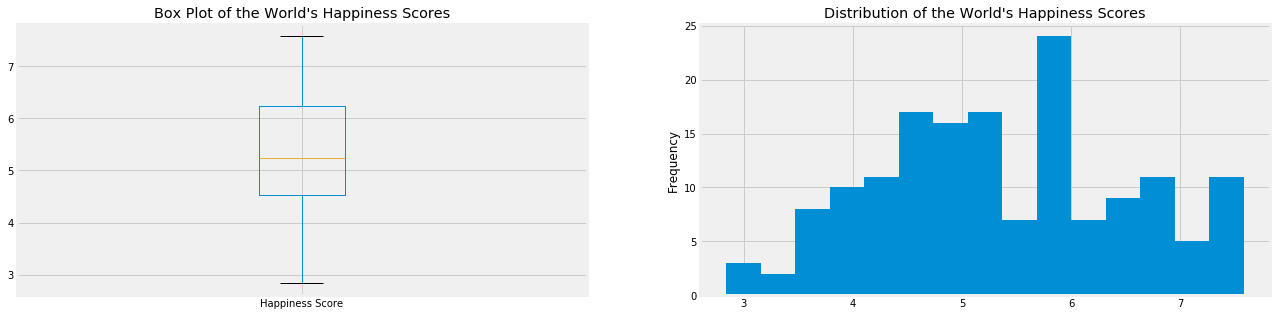

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
fig1 = countries_df['Happiness Score'].plot.box(ax = ax[0], title="Box Plot of the World's Happiness Scores")
fig2 = countries_df['Happiness Score'].plot.hist(bins = 15, ax = ax[1], title="Distribution of the World's Happiness Scores")

From these graphs, it's clear that the happiness scores follow a somewhat normal distribution. The mean value is about 5.2 with a range of 2.8 to 7.8. There doesn't appear to be much of a skew and there are not many outliers. 

Below, we will begin to look at the relationship between certain regions and their happiness scores. 

In [20]:
countries_df.groupby('Region')['Happiness Score'].mean().sort_values().plot.bar(title = 'Happiness Score by Region')

It's clear that there is a relationship between region and mean happiness score. The happiest regions also happen to be the wealthiest regions which is a relationship that will become more obvious as we do more analysis. 

Below, we take a look at the correlation between each variable and happiness and then select the ones with high correlation values. Since a correlation can be negative, we look at large positive or negative correlation values and then plot them below to show which variables have the strongest correlation.

In [21]:
happiness_corr_df = countries_df.corr()
happiness_corr_df = happiness_corr_df[(happiness_corr_df['Happiness Score'] >= .4) | (happiness_corr_df['Happiness Score'] <= -.4)]["Happiness Score"]
happiness_corr_df = happiness_corr_df.drop('Happiness Score')
happiness_corr_df = happiness_corr_df.sort_values()
happiness_corr_df.plot.bar(title = 'Largest Correlation Values for Happiness Score')


This graph shows us that high values for life expectancy at birth, internet users per capita, and GDP per capita are good indicators of a happy country. Good indicators of an unhappy country are high infant mortality rate, total fertility rate, and unemployment rate. It is interesting to see birth rate and total fertility rate as indicators of an unhappy country and not a category like children under the age of 5 underweight. Internet users per capita was also a surprising one to us as one of the strongest indicators as we figured there would be some other categories that would be more telling.

Additionally, happiness rank is at -1 because as happiness score gets higher, the rank gets lower. The #1 country in rank would be have the highest happiness score. This confused us for a little bit when we were looking at this graph, so we figured it would be best to explain that here.

The following code will begin to prepare our dataframe to display a chloropleth map of happiness scores for the world.

In [22]:
world_map_df = geo.read_file('Countries_WGS84.shp')
world_map_key_df = pd.read_csv('Countries_WGS84.csv')
world_map_df = world_map_df.merge(world_map_key_df, how = 'left', left_index = True, right_index = True )
world_map_df.head()

geometry  OBJECTID           CNTRY_NAME
0  POLYGON ((-69.88223 12.41111, -69.94695 12.436...         1                Aruba
1  MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ...         2  Antigua and Barbuda
2  POLYGON ((61.27656 35.60725, 61.29638 35.62853...         3          Afghanistan
3  POLYGON ((-5.15213 30.18047, -5.13917 30.19236...         4              Algeria
4  MULTIPOLYGON (((45.02583 41.03055, 45.00999 41...         5           Azerbaijan

In [23]:
#Countries to rename
world_map_df.at[25, 'Name'] = 'Myanmar'
world_map_df.at[27, 'Name'] = 'Belarus'
#Adding greenland as part of denmark
world_map_df.at[86, 'Name'] = 'Denmark'

In [24]:
world_map_df = world_map_df.merge(countries_df, left_on = 'CNTRY_NAME', right_on = 'Country', how = 'left')
world_map_df = world_map_df[world_map_df["CNTRY_NAME"] != "Antarctica"]


/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


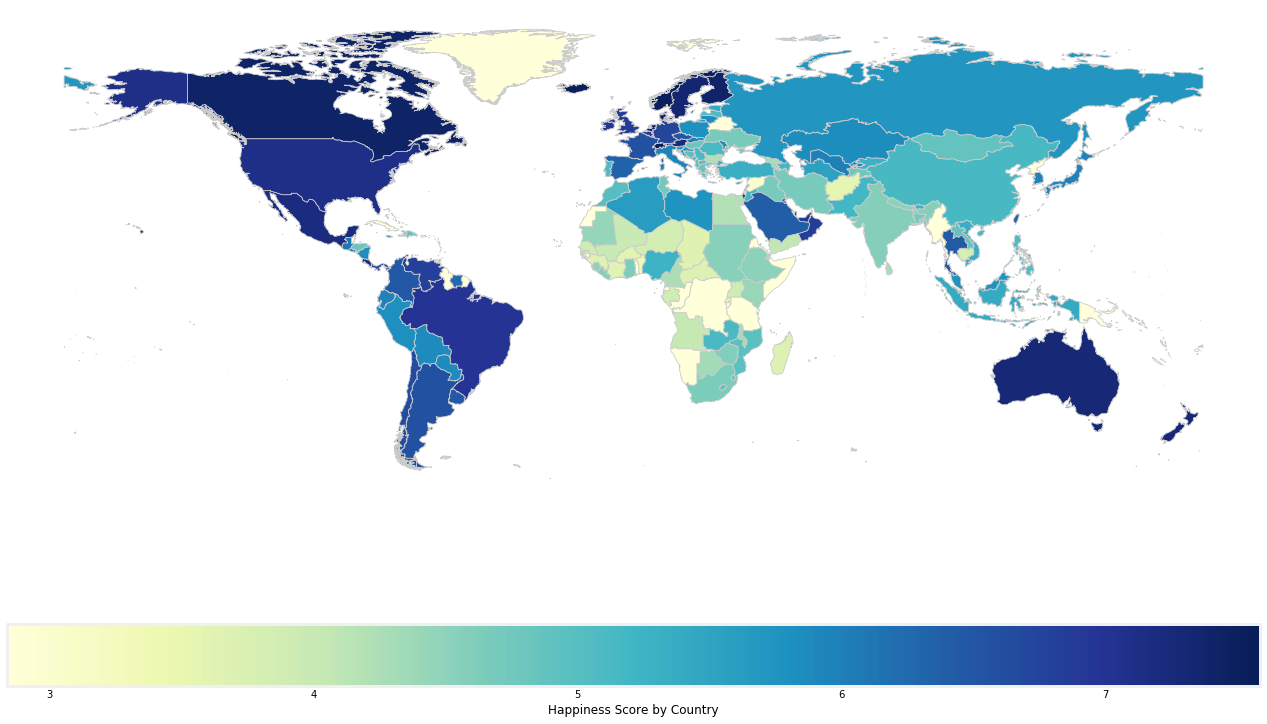

In [25]:
# set the range for the choropleth
vmin, vmax = 120, 220
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 15))

world_map_df.plot(column='Happiness Score', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor = '0.8', legend=True, legend_kwds = {'label': "Happiness Score by Country", 'orientation': "horizontal"})
ax.set_axis_off()
plt.show()

Wealthy countries like the United States, Canada, Australia, and a lot of northern Europe are very happy. Africa is the clear saddest continent which makes sense as there are a lot of poverty-ridden areas there. Asia is also not very happy.

Take note in the above graph that Greenland does not have a happiness score. Therefore, although it looks like a bleak place in this graph, it is only because there is just a NaN value there.

## County Data

The county data was acquired from these sources:

https://www.ers.usda.gov/data-products/county-level-data-sets/

https://policyinformatics.asu.edu/broadband-data-portal/dataaccess/countydata


There is a lot of county data that we need and we will start loading and tidying csv files here. We will only use data from the most recent year we can find and then standardize the data over the year so we can compare the most recent data to the standardized 2015 data from the world factbook. First, we will load in a dataset that contains population estimates for counties.

In [26]:
state_pop_df = pd.read_csv('PopulationEstimates.csv')
state_pop_df.head()

FIPS State       Area_Name Census Pop 2010 Estimates Base 2010 Pop Estimate 2010 Pop Estimate 2011 Pop Estimate 2012 Pop Estimate 2013 Pop Estimate 2014  ... Natural increase rate 2017 Natural increase rate 2018 Net migration rate 2011 Net migration rate 2012  Net migration rate 2013  Net migration rate 2014  Net migration rate 2015  Net migration rate 2016  Net migration rate 2017  Net migration rate 2018
0     0    US   United States     308,745,538         308,758,105       309,326,085       311,580,009       313,874,218       316,057,727       318,386,421  ...                        NaN                        NaN                     NaN                     NaN                      NaN                      NaN                      NaN                      NaN                      NaN                      NaN
1  1000    AL         Alabama       4,779,736           4,780,138         4,785,448         4,798,834         4,815,564         4,830,460         4,842,481  ...                        1.1                        0.8                     0.5                     1.2                      1.6                      0.6                      0.6                      0.8                      1.1                      1.9
2  1001    AL  Autauga County          54,571              54,574            54,754            55,208            54,936            54,713            54,876  ...                        2.7                        2.2                     6.0                    -6.1                     -3.9                      2.0                     -1.9                      5.3                      1.0                      0.6
3  1003    AL  Baldwin County         182,265             182,264           183,111           186,540           190,143           194,886           199,189  ...                        0.8                        0.1                    16.3                    17.6                     22.9                     20.2                     17.9                     21.5                     22.5                     24.8
4  1005    AL  Barbour County          27,457              27,457            27,330            27,350            27,174            26,944            26,758  ...                       -1.0                       -2.5                     0.3                    -6.8                     -8.1                     -5.1                    -15.5                    -18.2                    -25.0                     -8.6

[5 rows x 46 columns]

There are some columns that are empty due to the way that the data was loaded in. First, we will drop those columns as well as the row containing the United States data (as that is irrelevant here).

After we filter these columns, we will get rid of all data except for the most recent year.

In [27]:
state_pop_df = state_pop_df[state_pop_df.columns.drop(list(state_pop_df.filter(regex='Unnamed')))]
state_pop_df = state_pop_df.drop(0)

lst = [i + 2010 for i in range(8)]


for i in lst:
    i = str(i)
    if i=="2010":
        state_pop_df = state_pop_df.drop(['Pop Estimate ' + i], axis=1)
        state_pop_df = state_pop_df.drop(['Estimates Base ' + i], axis=1)
        state_pop_df = state_pop_df.drop(['Census Pop ' + i], axis=1)
    else:
        state_pop_df = state_pop_df.drop(['Pop Estimate ' + i], axis=1)
        state_pop_df = state_pop_df.drop(['Net migration rate '  + i], axis=1)
        state_pop_df = state_pop_df.drop(['Birth rate ' + i], axis=1)
        state_pop_df = state_pop_df.drop(['Death rate ' + i], axis=1)
        state_pop_df = state_pop_df.drop(['Natural increase rate ' + i], axis=1)

state_pop_df.head()

FIPS State       Area_Name Pop Estimate 2018  Birth rate 2018  Death rate 2018  Natural increase rate 2018  Net migration rate 2018
1  1000    AL         Alabama         4,887,871             11.7             10.9                         0.8                      1.9
2  1001    AL  Autauga County            55,601             11.8              9.6                         2.2                      0.6
3  1003    AL  Baldwin County           218,022             10.5             10.3                         0.1                     24.8
4  1005    AL  Barbour County            24,881             10.4             12.9                        -2.5                     -8.6
5  1007    AL     Bibb County            22,400             11.1             11.4                        -0.3                     -6.6

Now, we will look at a dataframe containing county wide unemployment data. We need to again drop the United States row as well as all of the unnamed columns. We will also remove all but the most recent data. Area_name in this data set is not initially conducive to later joins, so we will split the area name into two different columns containing the county name and the state name

In [28]:
state_unemployment_df = pd.read_csv('Unemployment.csv')
state_unemployment_df = state_unemployment_df[state_unemployment_df.columns.drop(list(state_unemployment_df.filter(regex='Unnamed')))]
state_unemployment_df = state_unemployment_df.drop(0)

lst = [i + 2007 for i in range(11)]

for i in lst:
    i = str(i)
    state_unemployment_df = state_unemployment_df.drop(['Unemployment_rate_' + i], axis=1)

state_unemployment_df[['Area_Name', 'State_Name']] = state_unemployment_df["Area_name"].str.split(", ", expand=True)
state_unemployment_df = state_unemployment_df.drop(["State", "Area_name"], axis=1)
state_unemployment_df.head()

FIPS  Unemployment_rate_2018 Median_Household_Income_2017  Med_HH_Income_Percent_of_State_Total_2017       Area_Name State_Name
1  1000.0                     3.9                      $48,193                                      100.0         Alabama       None
2  1001.0                     3.6                      $58,343                                      121.1  Autauga County         AL
3  1003.0                     3.6                      $56,607                                      117.5  Baldwin County         AL
4  1005.0                     5.2                      $32,490                                       67.4  Barbour County         AL
5  1007.0                     4.0                      $45,795                                       95.0     Bibb County         AL

We will now load in a dataset that contains county wide life expectancy data. We need to, again, perform similar tasks to drop the United States row, split the location into two columns, and drop all but the most recent data.

In [29]:
county_life_exp_df = pd.read_csv('County Life Expectancy.csv')
county_life_exp_df = county_life_exp_df.drop(0)
county_life_exp_df[['Area_Name', 'State_Name']] = county_life_exp_df["Location"].str.split(", ", expand=True)
county_life_exp_df = county_life_exp_df.drop(['Location'], axis=1)

lst = [i + 1980 for i in range(7)]

c=0
for i in lst:
    i = c+i
    i = str(i)
    county_life_exp_df = county_life_exp_df.drop(['Life expectancy, ' + i], axis=1)
    c+=4
county_life_exp_df.head()

FIPS Life expectancy, 2014       Area_Name State_Name
1     1.0  75.65 (75.57, 75.72)         Alabama       None
2  1001.0  75.67 (75.15, 76.18)  Autauga County    Alabama
3  1003.0  78.08 (77.72, 78.43)  Baldwin County    Alabama
4  1005.0  75.42 (74.78, 76.07)  Barbour County    Alabama
5  1007.0  73.97 (73.28, 74.68)     Bibb County    Alabama

We will now load in a dataset that contains county wide internet per capita. We will only take the data it has in it's most recent year (2016), since we will be standardizing all of this anyway. It unfortunately gives us the state name as the full name, so to perform our first merge we will replace all of the full names with abbreviations. Don't worry, we found this dictionary value online so we did not need to type out everything ourselves.

In [30]:
county_internet_df = pd.read_csv('county_internet.csv')
county_internet_df = county_internet_df[county_internet_df["year"] ==2016]
county_internet_df = county_internet_df.rename(columns={'county': 'Area_Name', 'state': 'State'})
#Don't worry, we found this dictionary online, we didn't go through the pain of typing it ourselves
d = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}
county_internet_df = county_internet_df.replace(d)


Now, we can start merging the data. First, we will merge the internet users per capita data with the county population data. This will be merged on both the area name and the state name to make sure that there are no duplicate counties.

In [31]:
county_merge_df = pd.merge(county_internet_df, state_pop_df, on=["Area_Name", "State"], how="outer")
county_merge_df = county_merge_df.drop(['year'], axis=1)
county_merge_df = county_merge_df.rename(columns={'broadband_home': 'Internet users per capita'})
county_merge_df.head()

State       Area_Name  Internet users per capita    FIPS Pop Estimate 2018  Birth rate 2018  Death rate 2018  Natural increase rate 2018  Net migration rate 2018
0    AL  Baldwin County                   0.771539  1003.0           218,022             10.5             10.3                         0.1                     24.8
1    AL  Calhoun County                   0.721937  1015.0           114,277             11.3             13.1                        -1.8                     -1.6
2    AL  Cullman County                   0.723159  1043.0            83,442             11.8             12.5                        -0.7                      8.1
3    AL   DeKalb County                   0.685971  1049.0            71,385             11.4             11.3                         0.1                     -0.4
4    AL   Elmore County                   0.816695  1051.0            81,887             11.0             10.0                         1.0                      4.8

Now, we will first merge the county life expectancy data with the above (merged) dataframe. We will merge this on the FIPS column which is a unique identifier for every county in America.

In [32]:
county_merge1_df = pd.merge(county_life_exp_df, county_merge_df, on="FIPS", how="inner")
county_merge1_df = county_merge1_df.drop(['State_Name', 'Area_Name_y'], axis=1)
county_merge1_df = county_merge1_df.rename(columns={'Area_Name_x': 'Area_Name'})
county_merge1_df.head()

FIPS Life expectancy, 2014       Area_Name State  Internet users per capita Pop Estimate 2018  Birth rate 2018  Death rate 2018  Natural increase rate 2018  Net migration rate 2018
0  1001.0  75.67 (75.15, 76.18)  Autauga County    AL                        NaN            55,601             11.8              9.6                         2.2                      0.6
1  1003.0  78.08 (77.72, 78.43)  Baldwin County    AL                   0.771539           218,022             10.5             10.3                         0.1                     24.8
2  1005.0  75.42 (74.78, 76.07)  Barbour County    AL                        NaN            24,881             10.4             12.9                        -2.5                     -8.6
3  1007.0  73.97 (73.28, 74.68)     Bibb County    AL                        NaN            22,400             11.1             11.4                        -0.3                     -6.6
4  1009.0  76.16 (75.66, 76.69)   Blount County    AL                        NaN            57,840             11.8             11.4                         0.3                      0.0

We can now merge the unemployment data with the previous data and tidy it up in the same way that we tidied the previous data

In [33]:
county_merge2_df = pd.merge(county_merge1_df, state_unemployment_df, on="FIPS", how="inner")
county_merge2_df = county_merge2_df.drop(['Area_Name_y', 'State_Name'], axis=1)
county_merge2_df = county_merge2_df.rename(columns = {'Area_Name_x': 'Area_Name'})
county_merge2_df['Life expectancy, 2014'] = county_merge2_df['Life expectancy, 2014'].str[:5]
county_merge2_df.head()

FIPS Life expectancy, 2014       Area_Name State  Internet users per capita Pop Estimate 2018  Birth rate 2018  Death rate 2018  Natural increase rate 2018  Net migration rate 2018  Unemployment_rate_2018 Median_Household_Income_2017  Med_HH_Income_Percent_of_State_Total_2017
0  1001.0                 75.67  Autauga County    AL                        NaN            55,601             11.8              9.6                         2.2                      0.6                     3.6                      $58,343                                      121.1
1  1003.0                 78.08  Baldwin County    AL                   0.771539           218,022             10.5             10.3                         0.1                     24.8                     3.6                      $56,607                                      117.5
2  1005.0                 75.42  Barbour County    AL                        NaN            24,881             10.4             12.9                        -2.5                     -8.6                     5.2                      $32,490                                       67.4
3  1007.0                 73.97     Bibb County    AL                        NaN            22,400             11.1             11.4                        -0.3                     -6.6                     4.0                      $45,795                                       95.0
4  1009.0                 76.16   Blount County    AL                        NaN            57,840             11.8             11.4                         0.3                      0.0                     3.5                      $48,253                                      100.1

We need to turn all the columns that we want to standardize into floats with no commas or dollar signs. This will be done in the cell below

In [34]:
object_cols = ['Pop Estimate 2018','Median_Household_Income_2017', 'Life expectancy, 2014']

for i in object_cols:

    county_merge2_df[i] = county_merge2_df[i].str.replace(',', "")
    county_merge2_df[i] = county_merge2_df[i].str.replace('$', "")
    
    county_merge2_df[i] = county_merge2_df[i].astype('float64')

The following code will standardize all the numerical columns in the graph so they can be used later to compare with the country data from the world factbook. We also rename the columns here as the previous column names would no longer be accurate.

In [35]:
standardized_county_df = county_merge2_df.drop(['Area_Name', 'State', 'FIPS'], axis = 1)

standardized_county_df = (standardized_county_df-standardized_county_df.mean())/standardized_county_df.std()

standardized_county_df.insert(0, 'Area_Name', county_merge2_df['Area_Name'])
standardized_county_df.insert(0, 'State', county_merge2_df['State'])
standardized_county_df.insert(0, 'FIPS', county_merge2_df['FIPS'])

standardized_county_df = standardized_county_df.rename(columns = {"Life expectancy, 2014": "Life expectancy", "Pop Estimate 2018": "Pop Estimate", "Birth rate 2018": "Birth rate", "Death rate 2018": "Death rate", "Natural increase rate 2018": "Natural increase rate", "Net migration rate 2018": "Net migration rate", "Unemployment_rate_2018": "Unemployment rate", "Median_Household_Income_2017": "Median household income", "Med_HH_Income_Percent_of_State_Total_2017": "Median household income percent of state total"})
standardized_county_df.head()

FIPS State       Area_Name  Life expectancy  Internet users per capita  Pop Estimate  Birth rate  Death rate  Natural increase rate  Net migration rate  Unemployment rate  Median household income  Median household income percent of state total
0  1001.0    AL  Autauga County        -0.873113                        NaN     -0.145590    0.250396   -0.284766               0.343824           -0.045029          -0.353223                 0.537597                                        1.594697
1  1003.0    AL  Baldwin County         0.138702                  -0.613009      0.341379   -0.266146   -0.024091              -0.173725            2.080241          -0.353223                 0.409047                                        1.415271
2  1005.0    AL  Barbour County        -0.978073                        NaN     -0.237694   -0.305880    0.944130              -0.814500           -0.852983           0.724706                -1.376808                                       -1.081743
3  1007.0    AL     Bibb County        -1.586841                        NaN     -0.245133   -0.027742    0.385541              -0.272306           -0.677341          -0.083741                -0.391578                                        0.293858
4  1009.0    AL   Blount County        -0.667391                        NaN     -0.138877    0.250396    0.385541              -0.124434           -0.097722          -0.420593                -0.209564                                        0.548045

Upon closer examination of our dataframe, Washington DC was left out of several dataframes that we merged together. Due to a lack of data, we will remove all rows containing values for DC so as to not skew the rest of our data.

We also noticed that there were some NaN values in the internet users per capita column. To rectify this, we mean imputed for the NaN values. However, we did not just simply take the mean of the entire column. In hopes to be mildly more accurate, we took the mean of each state and imputed that mean for each NaN-containing county in that state. This is a more regional way to mean impute and hopefully gives us more realistic data.

In [36]:
standardized_county_df = standardized_county_df[standardized_county_df["State"] != "DC"]
standardized_county_df["Internet users per capita"] = standardized_county_df.groupby("State")["Internet users per capita"].transform(lambda x: x.fillna(x.mean()))
standardized_county_df.head()

FIPS State       Area_Name  Life expectancy  Internet users per capita  Pop Estimate  Birth rate  Death rate  Natural increase rate  Net migration rate  Unemployment rate  Median household income  Median household income percent of state total
0  1001.0    AL  Autauga County        -0.873113                  -0.747618     -0.145590    0.250396   -0.284766               0.343824           -0.045029          -0.353223                 0.537597                                        1.594697
1  1003.0    AL  Baldwin County         0.138702                  -0.613009      0.341379   -0.266146   -0.024091              -0.173725            2.080241          -0.353223                 0.409047                                        1.415271
2  1005.0    AL  Barbour County        -0.978073                  -0.747618     -0.237694   -0.305880    0.944130              -0.814500           -0.852983           0.724706                -1.376808                                       -1.081743
3  1007.0    AL     Bibb County        -1.586841                  -0.747618     -0.245133   -0.027742    0.385541              -0.272306           -0.677341          -0.083741                -0.391578                                        0.293858
4  1009.0    AL   Blount County        -0.667391                  -0.747618     -0.138877    0.250396    0.385541              -0.124434           -0.097722          -0.420593                -0.209564                                        0.548045

## Exploratory Data Analysis

There is not too much we can do with data analysis yet with just the county data (before we connect it to the happiness metric from the world factbook), but here is a little bit of data analysis to start.

If we wanted to look at how all the county data correlates with each other we could plot a heatmap of their correlation. It is interesting to us that when it is plotted it can be seen that life expectancy and median household income have a correlation of 0.65. Death rate and median household income are pretty negatively correlated -0.54. Life expectancy and internet users per capita have a relatively high correlation at 0.49. Other than these, the rest are either not very correlated or uninterestingly correlated (like birth rate and natural increase rate).

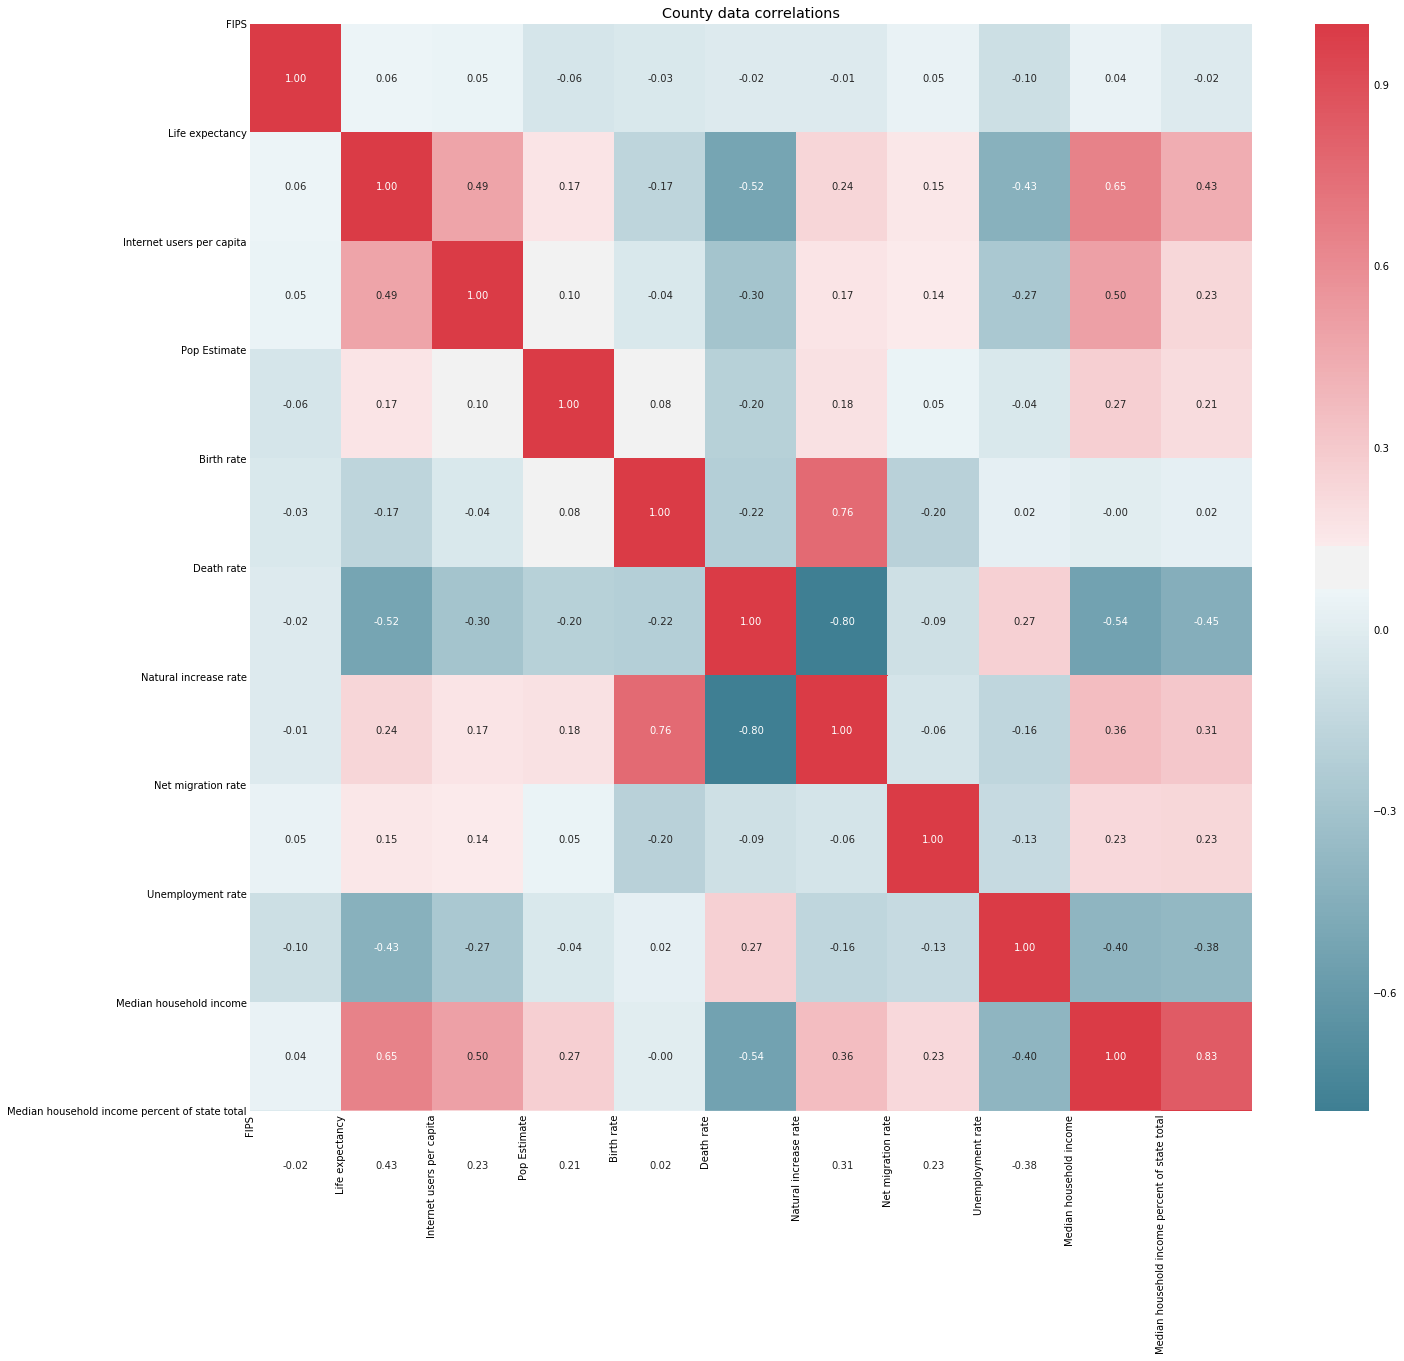

In [37]:
corr = standardized_county_df.corr()
fig, ax = plt.subplots(figsize=(20,20))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, annot=True, fmt = ".2f")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("County data correlations")
plt.show()

We can also make some bar charts with some of the more interesting data collected. Shown below is the median household income by state, life expectancy by state, and unemployment rate by state. All of this was found by finding the mean of the counties for each state.

In [38]:
fig, ax = plt.subplots(figsize = (20,10))

ax1 = county_merge2_df.groupby('State')['Median_Household_Income_2017'].mean().sort_values().plot.bar(title = 'Median household income by state')

In [39]:
fig, ax = plt.subplots(figsize = (20,10))
ax2 = county_merge2_df.groupby('State')['Life expectancy, 2014'].mean().sort_values().plot.bar(title = 'Life expectancy by state')

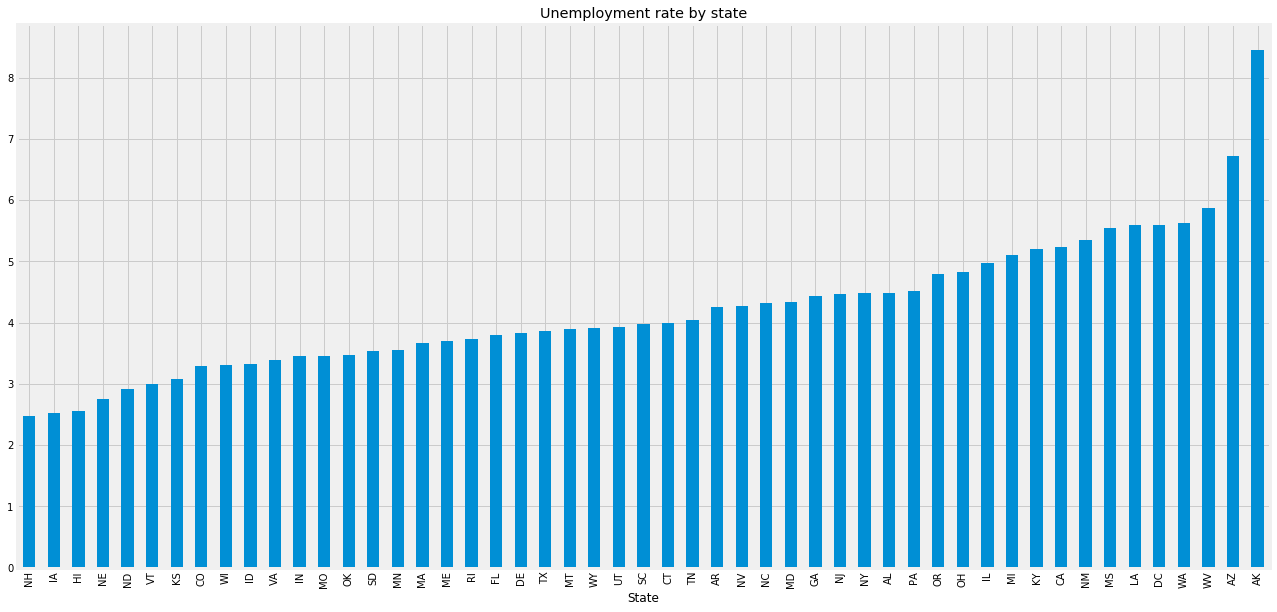

In [40]:
fig, ax = plt.subplots(figsize = (20,10))
ax2 = county_merge2_df.groupby('State')['Unemployment_rate_2018'].mean().sort_values().plot.bar(title = 'Unemployment rate by state')

It is clear that life expectancy is not very interesting at all, but household income and unemployment rate yield some more interesting figures. I find it interesting that DC is towards the top of both household income and unemployment.

## County Happiness

The following code will set up different models to test. We will choose whatever model ends up giving us the smallest root mean squared error upon cross validation.

In [41]:
#The relevant columns for the model
parameters = ['Happiness Score','Life expectancy at birth', 'Birth rate',
              'Death rate', 'Population', 'Unemployment rate', 'Net migration rate',
              'GDP - per capita (PPP)', 'Internet users per capita']
#The columns to be used as in the model
x_cols = ['Life expectancy at birth', 'Birth rate', 'Death rate',
             'Population', 'Unemployment rate', 'Net migration rate', 'GDP - per capita (PPP)', 'Internet users per capita']
#Creating a dataframe that just contains the necesary columns and DROPPING THE NA VALUES
model_df = standardized_country_df[parameters].dropna()
#Isolating the X_values and y_values
X_values = model_df[x_cols].values
y_values = model_df['Happiness Score'].values

In [42]:
#Splitting the data into training and testing data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_values, y_values, test_size=0.2, random_state=0)

In [43]:
#generating the three models to compare: lasso, linearRegression, and ridge
#For both lasso and ridge, various values of alpha were used
linear_model = sklearn.linear_model.LinearRegression()
lasso = sklearn.linear_model.Lasso()
lasso01 = sklearn.linear_model.Lasso(alpha = .01)
lasso0001 = sklearn.linear_model.Lasso(alpha = .0001)
ridge = sklearn.linear_model.Ridge()
ridge01 = sklearn.linear_model.Ridge(alpha = .01)
ridge100 = sklearn.linear_model.Ridge(alpha = 100)

In [44]:
#Function to get the rmse of a model based on 5-fold cross val analysis
def get_rmse_5_fold(model):
    scores = sklearn.model_selection.cross_val_score(model, X_values, y_values, cv = 5, scoring="neg_mean_squared_error")
    mse = np.mean(-scores)
    rmse = np.sqrt(mse)
    return rmse

In [45]:
#Getting the rmse for each model from the 10 fold cross val testing
linear_model_rmse = get_rmse_5_fold(linear_model)
lasso_rmse = get_rmse_5_fold(lasso)
lasso01_rmse = get_rmse_5_fold(lasso01)
lasso0001_rmse = get_rmse_5_fold(lasso0001)
ridge_rmse = get_rmse_5_fold(ridge)
ridge01_rmse = get_rmse_5_fold(ridge01)
ridge100_rmse = get_rmse_5_fold(ridge100)

In [46]:
#Displaying the rmse cross_val_scores of each model
print('Linear Model RMSE: ', linear_model_rmse)
print('Lasso RMSE: ', lasso_rmse)
print('Lasso with alpha = .01 RMSE: ', lasso01_rmse)
print('Lasso with alpha = .0001 RMSE: ', lasso0001_rmse)
print('Ridge RMSE: ', ridge_rmse)
print('Ridge with alpha = .01 RMSE: ', ridge01_rmse)
print('Ridge with alpha = 100 RMSE: ', ridge100_rmse)

Linear Model RMSE:  0.7823130224538987
Lasso RMSE:  1.1511127962562175
Lasso with alpha = .01 RMSE:  0.77516929829644
Lasso with alpha = .0001 RMSE:  0.7821251299317907
Ridge RMSE:  0.7767999970245985
Ridge with alpha = .01 RMSE:  0.7822463661152783
Ridge with alpha = 100 RMSE:  0.8079967748886043


The model that gives us the lowest root mean squared error is the lasso model with alpha .01. This is the one that we will fit to all of the countries.

In [47]:
#Fitting the ridge model to all the countries
lasso01.fit(X_train, y_train)
y_predicted = lasso01.predict(X_test)
y_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})

In [48]:
y_df.plot.bar(title = "actual vs predicted value for happiness score")
plt.legend(loc=1)
country_rmse = np.sqrt(((y_test - y_predicted) ** 2).mean())
country_rmse

0.4935357593887918

The graph above shows the actual versus the predicted value for happiness score for each of the countries that the lasso model attempted to predict. The average root mean squared error here for our actual versus predicted score is around 0.5 which is not fantastic. However, because we are only able to train on a small amount of countries, it is not too awful. If there were thousands of countries in the world that we could test on, our prediction would most likely yield more accurate results. 

We will now refit the lasso to take into account all of the countries in the dataframe (instead of fitting the lasso to 90% of the countries, we will be fitting it to 100% of the countries). We will use this re-fitted lasso to predict the happiness for individual counties in the United States.

In [49]:
lasso01.fit(X_values, y_values)
counties_test = standardized_county_df.rename(columns={"Life expectancy": 'Life expectancy at birth',
                                                                 'Pop Estimate': "Population",
                                                                'Median household income': 'GDP - per capita (PPP)'})

counties_test = counties_test.dropna()
counties_test['Predicted Happiness'] = lasso01.predict(counties_test[x_cols])

counties_test.head()

FIPS State       Area_Name  Life expectancy at birth  Internet users per capita  Population  Birth rate  Death rate  Natural increase rate  Net migration rate  Unemployment rate  GDP - per capita (PPP)  Median household income percent of state total  Predicted Happiness
0  1001.0    AL  Autauga County                 -0.873113                  -0.747618   -0.145590    0.250396   -0.284766               0.343824           -0.045029          -0.353223                0.537597                                        1.594697            -0.094265
1  1003.0    AL  Baldwin County                  0.138702                  -0.613009    0.341379   -0.266146   -0.024091              -0.173725            2.080241          -0.353223                0.409047                                        1.415271             0.220789
2  1005.0    AL  Barbour County                 -0.978073                  -0.747618   -0.237694   -0.305880    0.944130              -0.814500           -0.852983           0.724706               -1.376808                                       -1.081743            -0.846798
3  1007.0    AL     Bibb County                 -1.586841                  -0.747618   -0.245133   -0.027742    0.385541              -0.272306           -0.677341          -0.083741               -0.391578                                        0.293858            -0.561070
4  1009.0    AL   Blount County                 -0.667391                  -0.747618   -0.138877    0.250396    0.385541              -0.124434           -0.097722          -0.420593               -0.209564                                        0.548045            -0.278511

We have now added a new column to our counties dataframe. This column is what our lasso model predicts will be the happiness of the county. Now we can create a chloropleth map of the county wide data similar to the map we created for the world.

In [50]:
counties_map_df = geo.read_file('./UScounties.shp')

In [51]:
counties_map_df = counties_map_df.drop(['STATE_FIPS', 'CNTY_FIPS'], axis = 1)
counties_map_df = counties_map_df.astype({'FIPS': 'float64'})

We do not live in Alaska or Hawaii and they make the map look very stretched out and awkward, so we are going to drop these from the graphic.

In [52]:
counties_map_df = counties_map_df.merge(counties_test, how = 'left', on = 'FIPS')
counties_map_df = counties_map_df[counties_map_df.STATE_NAME != 'Alaska']
counties_map_df = counties_map_df[counties_map_df.STATE_NAME != 'Hawaii']


/opt/conda/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


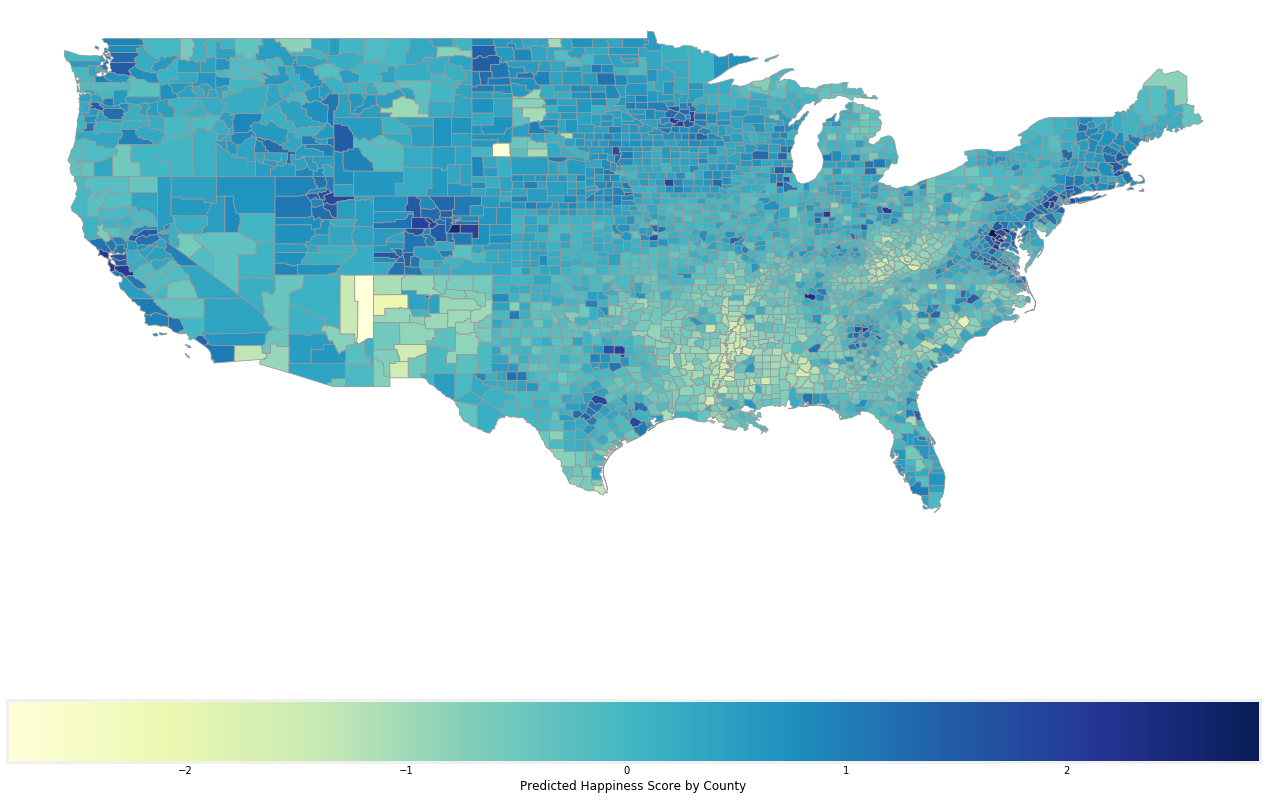

In [53]:
# set the range for the choropleth
vmin, vmax = 120, 220
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 20))
counties_map_df.plot(column='Predicted Happiness', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor = '0.6', legend = True, legend_kwds = {"label": "Predicted Happiness Score by County", "orientation": "horizontal"})
ax.set_axis_off()

plt.show()

This graph represents the conclusion of our project. We have successfully predicted the happiness of each and every county in the United States using a lasso model fitted to country happiness. As we discussed earlier, the model has the inherent flaw on only being able to train on a minimal number of countries, but we believe that the knowledge to be gained from this graph are still insightful. As you can see, the Northeast, coastal California, and some areas with major cities nearby are generally the happiest. There is a low point in the country near the Southeast (towards Louisiana) and Mideast (around West Virginia). We now have a predicted happiness for every county in the United States.

As a top 5 happiest counties graph is not very insightful for the general public, below you will see two dataframes displaying the top 5 happiest states and the top 5 saddest states. We determined this by taking the mean of all of a state's counties.

In [56]:
happy_states = counties_test.groupby("State")["Predicted Happiness"].mean().sort_values(ascending=False)
pd.DataFrame(happy_states).iloc[:5]

Predicted Happiness
State                     
CO                0.873887
MA                0.869995
NH                0.843984
CT                0.832461
RI                0.809976

In [57]:
pd.DataFrame(happy_states).iloc[-5:]

Predicted Happiness
State                     
AL               -0.586086
AR               -0.616932
NM               -0.624395
LA               -0.664435
MS               -0.832269

According to our prediction model, the top 5 happiest states (in order) are: Colorado, Massachusetts, New Hampshire, Connecticut, and Rhode Island. The top 5 saddest states according to our prediction model (in order of most sad first) are: Mississippi, Louisiana, New Mexico, Arkansas, and Alabama. 4 out of 5 of the happiest states are located in the Northeast and all 5 saddest states are located in the South.

In [58]:
counties_test.corr()['Predicted Happiness']

FIPS                                              0.078070
Life expectancy at birth                          0.825313
Internet users per capita                         0.727918
Population                                        0.181245
Birth rate                                       -0.057081
Death rate                                       -0.628071
Natural increase rate                             0.379691
Net migration rate                                0.330469
Unemployment rate                                -0.606130
GDP - per capita (PPP)                            0.855952
Median household income percent of state total    0.644810
Predicted Happiness                               1.000000
Name: Predicted Happiness, dtype: float64

Shown above is the correlation between everything in our counties dataframe and the county's predicted happiness according to our model. We did not include FIPS or Median household income percent of state total in our predictive model but everything else was utilized. As we can see, life expectancy at birth, internet users per capita, and GDP - per capita were used heavily to predict happiness as they correlate strongly. In the negative direction, death rate and unemployment rate indicated strong negative correlations with happiness.

Linked below are some articles relating to this project that might be interesting reads after you have read through this entire tutorial. The first article is a link to the world happiness report from 2019. The second link is an article that has claimed to rank the happiness of states in the U.S. The last link is a very brief article posted by fast company on where Americans are happiest and why. We hope you enjoyed this tutorial!

https://worldhappiness.report/ed/2019/

http://worldpopulationreview.com/states/happiest-states/

https://www.fastcompany.com/3039442/the-geography-of-happiness-where-americans-are-happiest-and-why